In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from operator import attrgetter
import seaborn as sns

In [3]:
data = pd.read_csv("db_customers.csv")
data.head()

Unnamed: 0                          order_id  \
0           0  e481f51cbdc54678b7cc49136f2d6af7   
1           1  e481f51cbdc54678b7cc49136f2d6af7   
2           2  e481f51cbdc54678b7cc49136f2d6af7   
3           3  53cdb2fc8bc7dce0b6741e2150273451   
4           4  47770eb9100c2d0c44946d9cf07ec65d   

                        customer_id order_status order_purchase_timestamp  \
0  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
1  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
2  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
3  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37   
4  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49   

  order_delivered_customer_date payment_type  payment_installments  \
0           2017-10-10 21:25:13  credit_card                   1.0   
1           2017-10-10 21:25:13      voucher                   1.0   
2           2017-10-10 21:25:13      voucher                   1.0   
3           2018-08-07 15:27:45       boleto                   1.0   
4           2018-08-17 18:06:29  credit_card                   3.0   

   payment_value  review_score                customer_unique_id  \
0          18.12             4  7c396fd4830fd04220f754e42b4e5bff   
1           2.00             4  7c396fd4830fd04220f754e42b4e5bff   
2          18.59             4  7c396fd4830fd04220f754e42b4e5bff   
3         141.46             4  af07308b275d755c9edb36a90c618231   
4         179.12             5  3a653a41f6f9fc3d2a113cf8398680e8   

   customer_zip_code_prefix customer_city customer_state  \
0                      3149     sao paulo             SP   
1                      3149     sao paulo             SP   
2                      3149     sao paulo             SP   
3                     47813     barreiras             BA   
4                     75265    vianopolis             GO   

  product_category_name_english  
0                    housewares  
1                    housewares  
2                    housewares  
3                     perfumery  
4                          auto

#### REFACTORISATION

In [16]:
def CalculFrequenceMonetaire(column:str, value:str):
    # calcul de la Fréquence & Monétaire     
    if value=="F":
        freq_mont = data.groupby(['customer_unique_id'])[column].size()
    else:
        freq_mont = data.groupby(['customer_unique_id'])[column].sum()
    freq_mont = freq_mont.to_frame(value).reset_index()
    return freq_mont

def data_cleaning(data:object):
    # Conversion en datetime     
    data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
    data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])
    # Suppression commandes annulées     
    data=data[['order_id','customer_unique_id','order_purchase_timestamp','payment_value']].loc[
    (data['order_status']!='canceled')&(data['order_status']!='unavailable')]
    return data

def calculate_RFM(data:object):
    # Récupération de la data clean    
    data = data_cleaning(data)
    # Calcul de la Recency
    data['R'] = (data['order_purchase_timestamp'].max()+ pd.Timedelta(days=1)-data['order_purchase_timestamp']).dt.days
    RFM=data.groupby(['customer_unique_id'])['R'].min()
    RFM= RFM.to_frame('R').reset_index()
    # Calcul frequency & monetaire     
    frequence = CalculFrequenceMonetaire(column="order_id",      value="F")
    monetaire = CalculFrequenceMonetaire(column="payment_value", value="M")
    RFM['F'] = frequence['F']
    RFM['M'] = monetaire['M']    
    # Scoring     
    RFM['R_score'] = pd.qcut(-(RFM['R']), q=3, labels=[1, 2, 3])
    RFM['M_score'] = pd.qcut(RFM['M'], q=3, labels=[1, 2, 3])
    RFM['F_score'] = RFM['F'].apply(lambda x: 1 if x == 1 else (2 if x <= 3 else 3))
    # string RFM     
    RFM['cluster']=RFM['R_score'].astype(str) + '-' + RFM['F_score'].astype(str) + '-' + RFM['M_score'].astype(str)
    return RFM

def cluster(champions:list, clients_risques:list, potentiels_loyaux:list,
            clients_perdition:list, one_shot:list, clients_récents:list):
    # Récupération du RFM     
    RFM = calculate_RFM(data)
    # Regroupement par catégorie     
    cluster = []
    for i in RFM["cluster"]:
        if i in champions:
            cluster.append("champions")
        elif i in bons_clients_risques:
            cluster.append("bons_clients_risques")
        elif i in potentiels_loyaux:
            cluster.append("potentiels_loyaux")
        elif i in petits_clients_perdition: 
            cluster.append("petits_clients_perdition")
        elif i[0:3] == "1-1" or i[0:3] == "2-1":
            cluster.append("one-shot")
        elif i in clients_récents:
            cluster.append("clients récents")
        else:
            cluster.append("pas de cluster")
    # Insertion de la colonne             
    RFM["cluster_group"] = cluster
    return RFM

In [17]:
champions                = ["3-2-3", "3-3-2", "3-3-3", "3-3-3", "2-3-3"]
bons_clients_risques     = ["1-3-3", "1-3-2", "1-2-3", "2-3-2"]
potentiels_loyaux        = ["3-2-2", "3-1-2", "3-2-1", "3-3-2", "2-3-2", "2-2-3", ]
petits_clients_perdition = ["1-2-2", "2-2-2", "2-2-1", "1-3-1", "1-2-1", "2-3-1"] 
one_shot                 = ["1-1"]
clients_récents          = ["3-1-1","3-1-3","3-1-2","3-3-1"]

In [18]:
clusters=cluster(champions, bons_clients_risques, potentiels_loyaux, petits_clients_perdition, one_shot, clients_récents)

In [19]:
clusters["cluster_group"].value_counts()

one-shot                    59188
clients récents             19372
potentiels_loyaux           12005
petits_clients_perdition     1692
bons_clients_risques         1377
champions                    1356
Name: cluster_group, dtype: int64

In [20]:
cluster_sans_one_shot = clusters[clusters['cluster_group'] !="one-shot" ]
fig = px.treemap(cluster_sans_one_shot, path=[px.Constant("all"), 'cluster_group'], 
                 values='M', color='F', color_continuous_scale=px.colors.sequential.PuBu)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [21]:
clusters

customer_unique_id    R  F       M R_score M_score  \
0      0000366f3b9a7992bf8c76cfdf3221e2  116  1  141.90       3       2   
1      0000b849f77a49e4a4ce2b2a4ca5be3f  119  1   27.19       3       1   
2      0000f46a3911fa3c0805444483337064  542  1   86.22       1       2   
3      0000f6ccb0745a6a4b88665a16c9f078  326  1   43.62       1       1   
4      0004aac84e0df4da2b147fca70cf8255  293  1  196.89       2       3   
...                                 ...  ... ..     ...     ...     ...   
94985  fffcf5a5ff07b0908bd4e2dbc735a684  452  1   71.06       1       1   
94986  fffea47cd6d3cc0a88bd621562a9d061  267  1   70.40       2       1   
94987  ffff371b4d645b6ecea244b27531430a  573  1   66.39       1       1   
94988  ffff5962728ec6157033ef9805bacc48  124  1  107.78       3       2   
94989  ffffd2657e2aad2907e67c3e9daecbeb  489  1   63.29       1       1   

       F_score cluster      cluster_group  
0            1   3-1-2  potentiels_loyaux  
1            1   3-1-1    clients récents  
2            1   1-1-2           one-shot  
3            1   1-1-1           one-shot  
4            1   2-1-3           one-shot  
...        ...     ...                ...  
94985        1   1-1-1           one-shot  
94986        1   2-1-1           one-shot  
94987        1   1-1-1           one-shot  
94988        1   3-1-2  potentiels_loyaux  
94989        1   1-1-1           one-shot  

[94990 rows x 9 columns]

In [22]:
fig = px.scatter_3d(clusters, x='R',y='F',z='M',color='cluster_group', opacity=0.8)
fig.show()

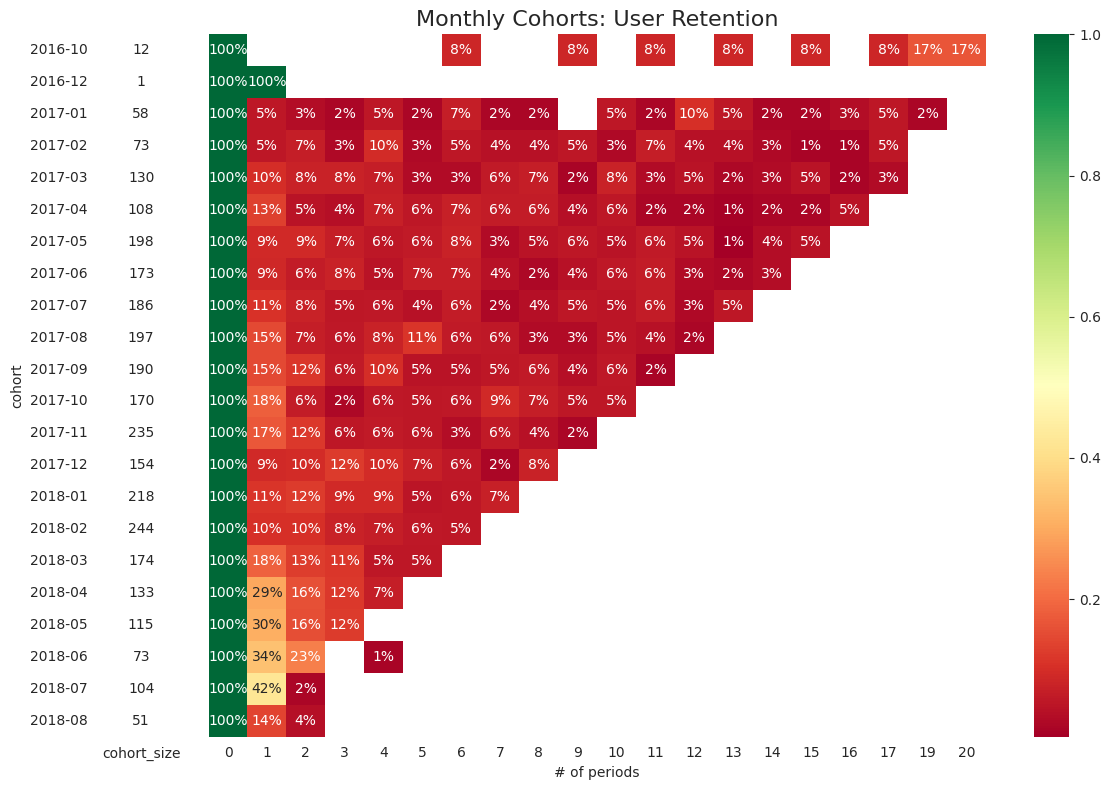

In [33]:
#start from your df created doing the RFM segmentation
df_c = data[['customer_unique_id', 'order_id',
           'order_purchase_timestamp']].drop_duplicates()

df_c['order_month'] = df_c['order_purchase_timestamp'].dt.to_period('M')

df_more = pd.DataFrame(df_c.groupby('customer_unique_id').size()[
                       df_c.groupby('customer_unique_id').size() > 1])

df_c = df_c.merge(df_more, how='left', on='customer_unique_id').rename(
    columns={0: 'na'})

df_c = df_c[df_c['na'].notna()]
df_c['cohort'] = df_c.groupby('customer_unique_id')['order_purchase_timestamp'] \
    .transform('min') \
    .dt.to_period('M')

df_cohort = df_c.groupby(['cohort', 'order_month']) \
    .agg(n_customers=('customer_unique_id', 'nunique')) \
    .reset_index(drop=False)
df_cohort['period_number'] = (
    df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
cohort_pivot = df_cohort.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='n_customers')
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={
                           'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(
        columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()